# Linear Models
## STA, MLE, Empirical Bayes and Spline-based Linear Gaussian model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

from rfest import splineLG, splineLNP, splineLNLN
from rfest.utils import uvec, split_data, build_design_matrix
from rfest.simulate import V1complex_2d, flickerbar, get_response
from rfest.plot import plot2d, plot_nonlinearity
from rfest.metrics import mse

Receptive field can be computed by Spike-Triggered Average (STA): 

$$\textrm{STA} = \frac{1}{n} X^{T}y$$

where $X$ is the stimulus design matrix, $y$ the response, and $n$ the number of spikes (or the number of frames in the stimulus if the response is continuous such as Calcium traces).

STA is simple to compute but it suffers from two problems:

1. it requires a lot of data to converge;
2. it doesn't work well with correlated stimulus, such as natural images.

We can fix the second problem by calculating the Maximum Likelihood Estimate (MLE), aks Whitened-STA:

$$\textrm{MLE} = (X^TX)^{-1} X^{T}y$$

yet this method will further exaggerate the "data-hunger" problem.

We can inspect these via simulation. Suppose we have a ground truth receptive field like this:

Text(0.5, 1.0, 'Ground Truth')

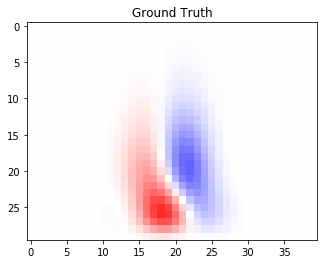

In [2]:
w_true = V1complex_2d()

plt.imshow(w_true, cmap=plt.cm.bwr, vmax=0.2, vmin=-0.2)
plt.title('Ground Truth')

and we can "record" some response by "stimulateing" it with some white noise and pink noise:

In [3]:
dims = w_true.shape
n_features = np.prod(dims)
n_samples = int(n_features * 32)
dt = 1

# white noise
X_wn = flickerbar(n_samples=n_samples, dims=dims, design_matrix=True, random_seed=0)
y_wn = get_response(X_wn, w_true.flatten(), dt=dt)

X_pn = flickerbar(n_samples=n_samples, dims=dims, beta=1, design_matrix=True, random_seed=0)
y_pn = get_response(X_pn, w_true.flatten(), dt=dt)

Text(0.5, 1.0, 'Pink Noise')

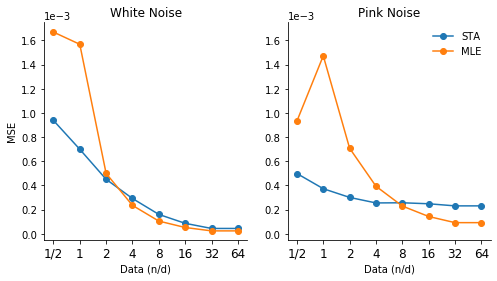

In [4]:
ws_sta_wn = []
ws_mle_wn = []

ws_sta_pn = []
ws_mle_pn = []

dt = 1
for scale in [0.5, 1, 2, 4, 8, 16, 32, 64]:
    
    n_samples = int(n_features * scale)

    w_sta_wn = X_wn[:n_samples].T @ y_wn[:n_samples] / n_samples
    w_mle_wn = np.linalg.inv(X_wn[:n_samples].T @ X_wn[:n_samples]) @ X_wn[:n_samples].T @ y_wn[:n_samples]
    
    ws_sta_wn.append(w_sta_wn)
    ws_mle_wn.append(w_mle_wn)
    
    w_sta_pn = X_pn[:n_samples].T @ y_pn[:n_samples] / n_samples
    w_mle_pn = np.linalg.pinv(X_pn[:n_samples].T @ X_pn[:n_samples]) @ X_pn[:n_samples].T @ y_pn[:n_samples]
    # even though the covariance is square, here we use pseudo-inverse instead because it yields more stable results.
    
    ws_sta_pn.append(w_sta_pn)
    ws_mle_pn.append(w_mle_pn)

fig, ax = plt.subplots(1,2, figsize=(8,4))

ax[0].plot([mse(uvec(w), uvec(w_true.flatten())) for w in ws_sta_wn], marker='o', label='STA')
ax[0].plot([mse(uvec(w), uvec(w_true.flatten())) for w in ws_mle_wn], marker='o', label='MLE')

ax[1].plot([mse(uvec(w), uvec(w_true.flatten())) for w in ws_sta_pn], marker='o', label='STA')
ax[1].plot([mse(uvec(w), uvec(w_true.flatten())) for w in ws_mle_pn], marker='o', label='MLE')

for i in range(2):
    ax[i].set_xticks(np.arange(8))
    xticklabel = ['1/2', '1', '2', '4', '8', '16', '32', '64']
    ax[i].set_xticklabels(xticklabel, fontsize=12)
    ax[i].ticklabel_format(axis='y', style='sci', useOffset=True, scilimits=(0,0))
    ax[i].set_ylim(-0.00005, 0.00175)
    
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].set_xlabel('Data (n/d)')

ax[1].legend(frameon=False)
ax[0].set_title('White Noise')
ax[0].set_ylabel('MSE')

ax[1].set_title('Pink Noise')

To solve the first problem, we resort to regularizing MLE by adding priors into the equation:
    
$$\textrm{Regularized MLE} = (X^TX + C^{-1})^{-1} X^{T}y$$

The choice of prior depends on the properties we desire a RF to have, such as sparsity (ARD), smoothness (ASD, Sahani & Linden, 2003), or locality (Park & Pillow, 2011). Choosing a prior is one thing, however, finding a good set of parameters for those priors is another. A popular method to find the best prior is called Evidence Optimzation, aka Empirical Bayes, which depends on minimizing the negative log evidence via gradient descent.

In [5]:
from rfest import ASD, ALD

# white noise
asd_wn = ASD(X_wn, y_wn, dims=dims)
asd_wn.fit(p0=[1., 1., 6., 6.,], num_iters=30, verbose=10)

sigma0 = [1.]
rho0 = [1.]
params_t0 = [3., 20., 1., 1.] # taus, nus, tauf, nuf
params_y0 = [3., 20., 1., 1.]
p0 = sigma0 + rho0 + params_t0 + params_y0
ald_wn = ALD(X_wn, y_wn, dims=dims)
ald_wn.fit(p0=p0, num_iters=30, verbose=10)

# pink noise
asd_pn = ASD(X_pn, y_pn, dims=dims)
asd_pn.fit(p0=[1., 1., 6., 6.,], num_iters=30, verbose=10)

sigma0 = [1.]
rho0 = [1.]
params_t0 = [3., 20., 1., 1.] # taus, nus, tauf, nuf
params_y0 = [3., 20., 1., 1.]
p0 = sigma0 + rho0 + params_t0 + params_y0
ald_pn = ALD(X_pn, y_pn, dims=dims)
ald_pn.fit(p0=p0, num_iters=30, verbose=10)

Iter	σ	ρ	δt	δs	cost
   0	1.010	0.990	6.010	6.010	71858.424
  10	1.107	0.929	6.072	6.072	69049.902
  20	1.193	0.894	6.066	6.075	67536.471
Stop: reached 30 steps, final cost=66931.38556.
* Due to space limit, parameters for frequency domain are not printed.
Iter	σ	ρ	τ_t	ν_t	τ_y	ν_y	cost
   0	1.010	1.010	3.010	19.990	3.010	20.010	63122.901
  10	1.107	0.986	2.980	20.018	2.981	19.975	60220.847
  20	1.193	0.973	2.965	20.035	2.959	19.986	58577.571
Stop: reached 30 steps, final cost=57863.20869.
Iter	σ	ρ	δt	δs	cost
   0	0.990	0.990	5.990	6.010	27537.481
  10	0.929	1.020	5.989	6.033	-1240294.491
  20	0.871	1.036	5.995	6.041	-4812255.621
Stop: reached 30 steps, final cost=43315.13875.
* Due to space limit, parameters for frequency domain are not printed.
Iter	σ	ρ	τ_t	ν_t	τ_y	ν_y	cost
   0	1.010	0.990	2.990	20.010	2.990	20.010	96946.981
  10	1.108	1.010	3.016	19.972	2.916	20.067	88017.426
  20	1.199	0.984	3.000	19.981	2.867	20.100	82067.359
Stop: reached 30 steps, final cost=78577.28198.


In [6]:
ws_asd_wn = []
ws_ald_wn = []

ws_asd_pn = []
ws_ald_pn = []


dt = 1
for scale in [0.5, 1, 2, 4, 8, 16, 32, 64]:
    
    n_samples = int(n_features * scale)

    w_asd_wn = asd_wn.optimized_C_post @ X_wn[:n_samples].T @ y_wn[:n_samples] / asd_wn.optimized_params[0]**2
    w_ald_wn = ald_wn.optimized_C_post @ X_wn[:n_samples].T @ y_wn[:n_samples] / ald_wn.optimized_params[0]**2
    
    w_asd_pn = asd_pn.optimized_C_post @ X_pn[:n_samples].T @ y_pn[:n_samples] / asd_pn.optimized_params[0]**2
    w_ald_pn = ald_pn.optimized_C_post @ X_pn[:n_samples].T @ y_pn[:n_samples] / ald_pn.optimized_params[0]**2
    
    ws_asd_wn.append(w_asd_wn)
    ws_ald_wn.append(w_ald_wn)
    ws_asd_pn.append(w_asd_pn)
    ws_ald_pn.append(w_ald_pn)

Text(0.5, 1.0, 'Pink Noise')

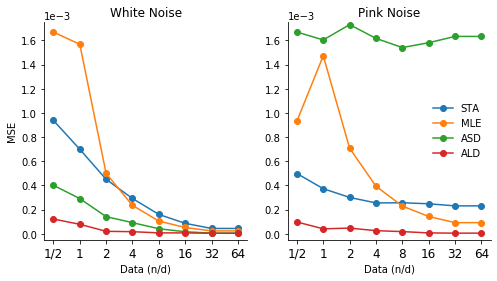

In [7]:
fig, ax = plt.subplots(1,2, figsize=(8, 4))

ax[0].plot([mse(uvec(w), uvec(w_true.flatten())) for w in ws_sta_wn], marker='o', label='STA')
ax[0].plot([mse(uvec(w), uvec(w_true.flatten())) for w in ws_mle_wn], marker='o', label='MLE')
ax[0].plot([mse(uvec(w), uvec(w_true.flatten())) for w in ws_asd_wn], marker='o', label='ASD')
ax[0].plot([mse(uvec(w), uvec(w_true.flatten())) for w in ws_ald_wn], marker='o', label='ALD')

ax[1].plot([mse(uvec(w), uvec(w_true.flatten())) for w in ws_sta_pn], marker='o', label='STA')
ax[1].plot([mse(uvec(w), uvec(w_true.flatten())) for w in ws_mle_pn], marker='o', label='MLE')
ax[1].plot([mse(uvec(w), uvec(w_true.flatten())) for w in ws_asd_pn], marker='o', label='ASD')
ax[1].plot([mse(uvec(w), uvec(w_true.flatten())) for w in ws_ald_pn], marker='o', label='ALD')


for i in range(2):
    ax[i].set_xticks(np.arange(8))
    xticklabel = ['1/2', '1', '2', '4', '8', '16', '32', '64']
    ax[i].set_xticklabels(xticklabel, fontsize=12)
    ax[i].ticklabel_format(axis='y', style='sci', useOffset=True, scilimits=(0,0))
    ax[i].set_ylim(-0.00005, 0.00175)
    
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].set_xlabel('Data (n/d)')

ax[1].legend(frameon=False)
ax[0].set_title('White Noise')
ax[0].set_ylabel('MSE')

ax[1].set_title('Pink Noise')

By incorporating priors into MLE, the amount of data needed to fit an unbias RF can be significant lowered (although in this simulation, ASD failed miserably in the case of Pink Noise). However, Evidence Optimization has its shortcoming too. As the cost function involved calculating the inverse of the the stimulus covariance and the prior in every step, the efficiency of the optimization will become very low as the number of coefficient in a RF increases (the time complexity is $O(d^3)$, where $d$ is the  number of coefficient in a RF). 

* (In this simulation, we "cheated" by reusing the same priors through all conditions, as we already know the ground truth and the best prior is easy to find. But in real cases, it's not easy to do so.) 

An alternative approach to fit a smooth and sparse receptive in an efficient way, is to interpolate it with basis functions. Popular choices such as Raised-Cosine has been used for 1D receptive field (Pillow, et al., 2008) or Gaussian spectral filters for 2D (Thorson, et al., 2015), yet there's no basis used for 3D yet. 

In RFEst, we use *natural cubic spline* as a good-enough basis. In fact, other splines such as cyclic cubic, B-spline, Thin-Plate spline are all getting similar performance, but we stick with natural cubic as it's been shown to be the smoothest interpolant ever (Wood, 2006).

Text(0.5, 1.0, 'Natural Cubic Spline')

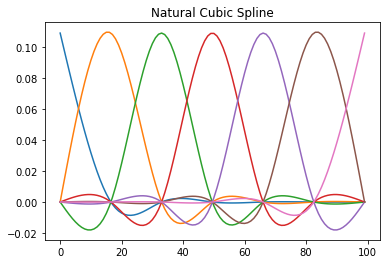

In [8]:
from rfest.splines import cr
S = cr(np.arange(100), 7)
plt.plot(S)
plt.title('Natural Cubic Spline')

A linear model with basis function can be rewritten as this:

$$ y = X\underbrace{Sb}_{w} + \epsilon, \epsilon \sim \mathcal{N}(\mu,\,\sigma^{2})$$

where $S$ is basis, $b$ the basis coefficients, the dot product of $S$ and $b$ is the RF $w$. The receptive field can be estimated by simply calculating the maximum likelihood or by gradient descent (which can enable us to add L1 regularization).

In practice, we also compute the dot product of $X$ and $S$ before optimzation, as this part is fixed in every step. The time complexity is now reduced from $O(d^3)$ to $O(b^3)$, admittedly that it's still cubic but since $b$ is much smaller than $d$ in most cases, the computation now becomes feasible.

In [9]:
ws_spl_mle_wn = []
ws_spl_l1_wn = []

df = [9, 12]
scales = [0.5, 1, 2, 4, 8, 16, 32, 64]
for scale in scales:
    
    n_samples = int(n_features * scale)

    lg = splineLG(X_wn[:n_samples], y_wn[:n_samples], dims=dims, dt=dt, df=df)
    lg.fit(metric='corrcoef',
          num_iters=3000, verbose=0, tolerance=10,
          beta=0.01)
    
    ws_spl_mle_wn.append(lg.w_spl)
    ws_spl_l1_wn.append(lg.w_opt)


Total time elapsed: 9.343 s.
Total time elapsed: 25.235 s.
Total time elapsed: 26.606 s.
Total time elapsed: 27.294 s.
Total time elapsed: 29.323 s.
Total time elapsed: 22.859 s.
Total time elapsed: 52.437 s.
Total time elapsed: 51.341 s.


In [10]:
ws_spl_mle_pn = []
ws_spl_l1_pn = []

df = [9, 12]
scales = [0.5, 1, 2, 4, 8, 16, 32, 64]
for scale in scales:
    
    n_samples = int(n_features * scale)

    lg = splineLG(X_pn[:n_samples], y_pn[:n_samples], dims=dims, dt=dt, df=df)
    lg.fit(metric='corrcoef',
          num_iters=3000, verbose=0, tolerance=10,
          beta=0.01)
    
    ws_spl_mle_pn.append(lg.w_spl)
    ws_spl_l1_pn.append(lg.w_opt)



Total time elapsed: 25.118 s.
Total time elapsed: 28.449 s.
Total time elapsed: 28.010 s.
Total time elapsed: 30.313 s.
Total time elapsed: 32.317 s.
Total time elapsed: 38.135 s.
Total time elapsed: 53.095 s.
Total time elapsed: 52.150 s.


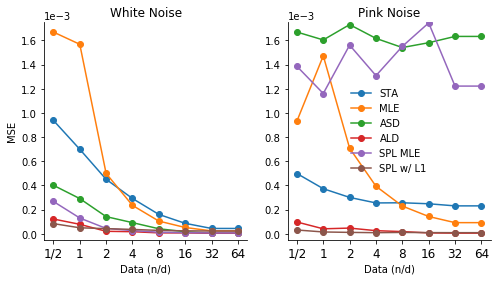

In [11]:
fig, ax = plt.subplots(1,2, figsize=(8, 4))

ax[0].plot([mse(uvec(w), uvec(w_true.flatten())) for w in ws_sta_wn], marker='o', label='STA')
ax[0].plot([mse(uvec(w), uvec(w_true.flatten())) for w in ws_mle_wn], marker='o', label='MLE')
ax[0].plot([mse(uvec(w), uvec(w_true.flatten())) for w in ws_asd_wn], marker='o', label='ASD')
ax[0].plot([mse(uvec(w), uvec(w_true.flatten())) for w in ws_ald_wn], marker='o', label='ALD')
ax[0].plot([mse(uvec(w), uvec(w_true.flatten())) for w in ws_spl_mle_wn], marker='o', label='SPL MLE')
ax[0].plot([mse(uvec(w), uvec(w_true.flatten())) for w in ws_spl_l1_wn], marker='o', label='SPL w/ L1')



ax[1].plot([mse(uvec(w), uvec(w_true.flatten())) for w in ws_sta_pn], marker='o', label='STA')
ax[1].plot([mse(uvec(w), uvec(w_true.flatten())) for w in ws_mle_pn], marker='o', label='MLE')
ax[1].plot([mse(uvec(w), uvec(w_true.flatten())) for w in ws_asd_pn], marker='o', label='ASD')
ax[1].plot([mse(uvec(w), uvec(w_true.flatten())) for w in ws_ald_pn], marker='o', label='ALD')
ax[1].plot([mse(uvec(w), uvec(w_true.flatten())) for w in ws_spl_mle_pn], marker='o', label='SPL MLE')
ax[1].plot([mse(uvec(w), uvec(w_true.flatten())) for w in ws_spl_l1_pn], marker='o', label='SPL w/ L1')

for i in range(2):
    ax[i].set_xticks(np.arange(8))
    xticklabel = ['1/2', '1', '2', '4', '8', '16', '32', '64']
    ax[i].set_xticklabels(xticklabel, fontsize=12)
    ax[i].ticklabel_format(axis='y', style='sci', useOffset=True, scilimits=(0,0))
    ax[i].set_ylim(-0.00005, 0.00175)
    
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].set_xlabel('Data (n/d)')

ax[1].legend(frameon=False)
ax[0].set_title('White Noise')
ax[0].set_ylabel('MSE')

ax[1].set_title('Pink Noise')

plt.legend(frameon=False)

## Estimated RF at n/d = 4

Text(0, 0.5, 'White Noise')

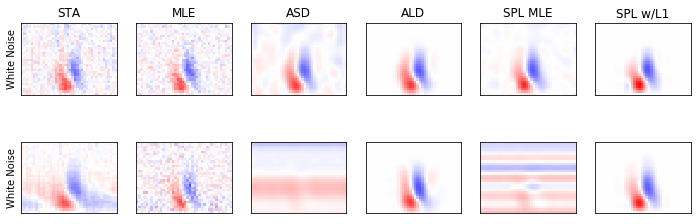

In [13]:
fig, ax = plt.subplots(2, 6, figsize=(12, 4))
    
ax[0, 0].imshow(uvec(ws_sta_wn[3]).reshape(dims), cmap=plt.cm.bwr, vmin=-0.2, vmax=0.2)
ax[0, 1].imshow(uvec(ws_mle_wn[3]).reshape(dims), cmap=plt.cm.bwr, vmin=-0.2, vmax=0.2)
ax[0, 2].imshow(uvec(ws_asd_wn[3]).reshape(dims), cmap=plt.cm.bwr, vmin=-0.2, vmax=0.2)
ax[0, 3].imshow(uvec(ws_ald_wn[3]).reshape(dims), cmap=plt.cm.bwr, vmin=-0.2, vmax=0.2)
ax[0, 4].imshow(uvec(ws_spl_mle_wn[3]).reshape(dims), cmap=plt.cm.bwr, vmin=-0.2, vmax=0.2)
ax[0, 5].imshow(uvec(ws_spl_l1_wn[3]).reshape(dims), cmap=plt.cm.bwr, vmin=-0.2, vmax=0.2)

ax[1, 0].imshow(uvec(ws_sta_pn[3]).reshape(dims), cmap=plt.cm.bwr, vmin=-0.2, vmax=0.2)
ax[1, 1].imshow(uvec(ws_mle_pn[3]).reshape(dims), cmap=plt.cm.bwr, vmin=-0.2, vmax=0.2)
ax[1, 2].imshow(uvec(ws_asd_pn[3]).reshape(dims), cmap=plt.cm.bwr, vmin=-0.2, vmax=0.2)
ax[1, 3].imshow(uvec(ws_ald_pn[3]).reshape(dims), cmap=plt.cm.bwr, vmin=-0.2, vmax=0.2)
ax[1, 4].imshow(uvec(ws_spl_mle_pn[3]).reshape(dims), cmap=plt.cm.bwr, vmin=-0.2, vmax=0.2)
ax[1, 5].imshow(uvec(ws_spl_l1_pn[3]).reshape(dims), cmap=plt.cm.bwr, vmin=-0.2, vmax=0.2)

labels = ['STA', 'MLE', 'ASD', 'ALD', 'SPL MLE', 'SPL w/L1']
for i in range(2):
    for j in range(6):
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        
        if i == 0:
            ax[i, j].set_title(labels[j])

ax[0, 0].set_ylabel('White Noise')
ax[1, 0].set_ylabel('White Noise')

